# Setup

In [1]:
import numpy as np
import scipy.linalg
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import math
import time
import glob
import os
import imageio
from quadprog import solve_qp

In [2]:
inv = np.linalg.inv
sqrtm = scipy.linalg.sqrtm
norm = np.linalg.norm

# Data generation

### Synthetic (iid sparse random uniform random variables)

In [102]:
# s_dim = 3 # source dimension
# x_dim = 3 # mixed stimuli dimension, must satisfy x_dim >= s_dim

# cwd = os.getcwd() # current working directory  

# path = f'{cwd}/data/synthetic/{s_dim}-dim-source' 

# # create directory if path does not exist

# if os.path.exists(path)==False:
#     os.makedirs(path)

# if os.path.exists(f'{path}/{x_dim}-dim-mixture')==False:
#     os.makedirs(f'{path}/{x_dim}-dim-mixture')

In [103]:
# samples = 10**5 # number of samples

# U = np.random.uniform(0,math.sqrt(48/5),(s_dim,samples)) # independent non-negative uniform source RVs with variance 1
# B = np.random.binomial(1, .5, (s_dim,samples)) # binomial RVs to sparsify the source
# S = U*B # sources

# filename = f'{path}/sources.npy'
# np.save(filename, S)

In [104]:
# A = np.random.randn(x_dim,s_dim) # random mixing matrix

# np.save(f'{path}/{x_dim}-dim-mixture/mixing-matrix.npy', A)

In [105]:
# S = np.load(f'{path}/sources.npy')
# A = np.load(f'{path}/{x_dim}-dim-mixture/mixing-matrix.npy')

# X = A@S

# filename = f'{path}/{x_dim}-dim-mixture/mixtures.npy'
# np.save(filename, X)

### Images

In [106]:
# s_dim = 3 # source dimension
# x_dim = 6 # mixed stimuli dimension, must satisfy x_dim >= s_dim

# cwd = os.getcwd() # current working directory  

# path = f'{cwd}/data/images/{s_dim}-dim-source' 

# # create directory if path does not exist

# if os.path.exists(path)==False:
#     os.makedirs(path)

# if os.path.exists(f'{path}/{x_dim}-dim-mixture')==False:
#     os.makedirs(f'{path}/{x_dim}-dim-mixture')

In [107]:
# 3 image patches are pre-specified

# if s_dim==3:
#     image_numbers = [5, 6, 11]; winsize=252
#     posx = [220, 250, 200]
#     posy = [1, 1, 1]

# S = np.zeros((s_dim, winsize**2))

# plt.figure(figsize=(15,10))

# for i in range(s_dim):
#     image = imageio.imread(f'data/images/{image_numbers[i]}.tiff')
#     window = image[posy[i]:posy[i] + winsize, posx[i]:posx[i] + winsize]
#     plt.subplot(s_dim, 1, i+1)
#     plt.imshow(window, cmap="gray")
#     np.save(f'{path}/source_{i}.npy', window)
#     window = window.reshape(1,-1)
#     window = window - window.min(axis=1)
#     window_var = np.cov(window)
#     window = window*(window_var**-.5)
#     S[i,:] = window

# plt.show()
    
# S = np.array(S)

# filename = f'{path}/sources.npy'
# np.save(filename, S)

In [108]:
# A = np.random.randn(x_dim,s_dim) # random mixing matrix

# np.save(f'{path}/{x_dim}-dim-mixture/mixing-matrix.npy', A)

In [109]:
# S = np.load(f'{path}/sources.npy')
# A = np.load(f'{path}/{x_dim}-dim-mixture/mixing-matrix.npy')

# X = A@S

# plt.figure(figsize=(15,10))

# for i in range(x_dim):
#     mixed = X[i].reshape(252,252)
#     plt.subplot(1, x_dim, i+1)
#     plt.imshow(mixed, cmap="gray")
#     np.save(f'{path}/{x_dim}-dim-mixture/mixture_{i}.npy', X[i])

# plt.show()

# filename = f'{path}/{x_dim}-dim-mixture/mixtures.npy'
# np.save(filename, X)

# Load data

In [3]:
dataset = 'synthetic'
# dataset = 'images'

In [4]:
s_dim = 3 # source dimension
x_dim = 3 # mixed stimuli dimension, must satisfy x_dim >= s_dim
y_dim = s_dim

In [5]:
S = np.load(f'data/{dataset}/{s_dim}-dim-source/sources.npy')
X = np.load(f'data/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/mixtures.npy')

In [6]:
samples = S.shape[1]

# Global parameters and permuted data

In [7]:
trials = 1; epochs = 1; iters = epochs*samples; report_num = 1

In [8]:
S_permuted = np.zeros((trials,s_dim,iters))
X_permuted = np.zeros((trials,x_dim,iters))

for n in range(trials):
    for m in range(epochs):
        idx = np.random.permutation(samples)
        S_permuted[n,:,m*samples:(m+1)*samples] = S[:,idx[:]]
        X_permuted[n,:,m*samples:(m+1)*samples] = X[:,idx[:]]

# Bio-NICA

### Parameters

In [9]:
a = 100; b = .01; tau = .1 # optimal parameters for 3-dimensional synthetic data
# a = 1000; b = .1; tau = .03 # optimal parameters for 10-dimensional synthetic data 
# a = 1000; b = .001; tau = .05 # optimal parameters for image data

### Online algorithm

Trial 1:
report number: 1


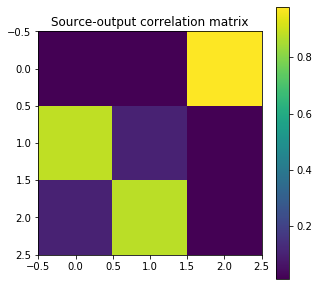

In [10]:
Y = np.zeros((trials,y_dim,iters)) # matrix for keeping track of the outputs across trials
error = np.zeros((trials,iters)) # matrix for keeping track of the error across trials

for n in range(trials):

    print('Trial {}:'.format(n+1))

    # initialize a random matrix W whose rows have norm 1:

    W = np.random.randn(y_dim,x_dim)
    for i in range(y_dim):
        W[i,:] = W[i,:]/norm(W[i,:])

    # initialize M to be the identity matrix:

    M = np.eye(y_dim)

    # inialize running means:

    x_bar = 0
    c_bar = 0

    start_time = time.time()

    for t in range(iters):

        # compute step size:

        eta_t = 1/(a+b*t)

        x = X_permuted[n,:,t]
        x_bar = x_bar + (x - x_bar)/(t+1) # running average of x 
        x_hat = x - x_bar # centered x

        c = W@x
        c_bar = c_bar + (c - c_bar)/100 # running weighted average of c
        c_hat = c - c_bar # centered c

        # neural dynamics

        y = solve_qp(M, c, np.eye(y_dim), np.zeros(y_dim))[0]; Y[n,:,t] = y

        # synaptic updates

        W = W + 2*eta_t*(np.outer(y,x) - np.outer(c_hat,x_hat))
        M = M + (eta_t/tau)*(np.outer(y,y) - M)

        # the matrix M can sometimes exhibit instaiblities due to noise, which can be addressed with the following ad hoc fix (the alternative is to reduce the learning rate):

        if scipy.linalg.det(M)<.001:
            M = M + .1*np.eye(y_dim)
#             print('M close to degenerate')

        # check to see if any neurons (i.e. components of y) are not firing after the first 10 samples

        if t<=100:
            for j in range(y_dim):
                if sum(Y[n,0:t,j])==0:
                    W[j,:] = -W[j,:]
#                     print('flip',j)

        # output

        if (t+1)%(iters/report_num)==0:

            print('report number:', np.int((t+1)*report_num/iters))
        
            # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

            corr = np.corrcoef(S_permuted[n,:,:t+1],Y[n,:,:t+1])[:s_dim,s_dim:]

            fig=plt.figure(figsize=(5,5))

            plt.imshow(corr)
            plt.title('Source-output correlation matrix')
            plt.colorbar()
            plt.show()

    # compute the optimal permutation matrix

    perm = np.round(np.corrcoef(S_permuted[n,:,:],Y[n,:,:]))[:s_dim,s_dim:] # if the algorithm performs well, rounding the correlation matrix yields the optimal permutation matrix

    # compute error

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

cwd = os.getcwd() # current working directory  

path = f'{cwd}/error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/bio-nica/a={a}/b={b}/tau={tau}'

if os.path.exists(path)==False:
    os.makedirs(path)

np.save(f'{path}/error.npy', error)

# 2-layer NSM

### Parameters

In [11]:
a = 10; b = .8 # optimal parameters for 3-dimensional synthetic data
# a = 10; b = .9 # optimal parameters for 10-dimensional synthetic data 

In [12]:
max_steps = 100

### Online algorithm

Trial 1:
report number: 1


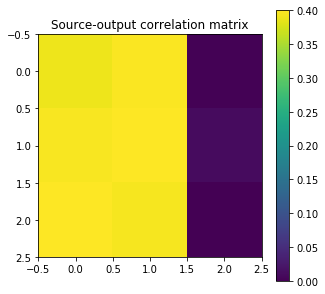

In [13]:
Y = np.zeros((trials,y_dim,iters)) # matrix for keeping track of the outputs across trials
error = np.zeros((trials,iters)) # matrix for keeping track of the error across trials

h_dim = y_dim

for n in range(trials):

    print('Trial {}:'.format(n+1))

    Whx = np.random.randn(h_dim,x_dim)
    Wgh = np.eye(h_dim)
    Wyh = np.random.randn(y_dim,h_dim)
    Wyy = np.zeros((y_dim,y_dim))
    D = np.zeros(y_dim)

    for i in range(h_dim):
        Whx[i,:] = Whx[i,:]/norm(Whx[i,:])
        Wyh[i,:] = Wyh[i,:]/norm(Wyh[i,:])

    x_bar = 0
    h_bar = 0
    g_bar = 0

    start_time = time.time()

    for t in range(iters):

        eta_t = 1/(100+t)

        x = X_permuted[n,:,t]
        x_bar = x_bar + (x - x_bar)/(t+1)
        x_hat = x - x_bar
        
        # whitening layer

        # neural dynamics

        h = inv(Wgh.T@Wgh)@Whx@x
        h_bar = h_bar + (h - h_bar)/(t+1)
        h_hat = h - h_bar

        g = Wgh@h
        g_bar = g_bar + (g - g_bar)/(t+1)
        g_hat = g - g_bar

        # synaptic updates

        Whx = Whx + eta_t*(np.outer(h_hat,x_hat) - Whx)
        Wgh = Wgh + eta_t*(np.outer(g_hat,h_hat) - Wgh)

        # rotation layer
        
        # neural dynamics
        
        c = Wyh@h
        
        err = 1; steps = 0; y = np.zeros(y_dim)
        
        while steps<max_steps:
            
            y_old = y
                        
            for j in range(y_dim):
                y[j] = max(c[j] - Wyy[j,:]@y_old,0.0)
                
            err = norm(y-y_old)/norm(y_old+0.001)
                
            steps = steps + 1
            
        Y[n,:,t] = y

        # synaptic updates
        
        y_sq = y**2
        
        D = np.maximum(a,b*D + y_sq)

        Wyh = Wyh + inv(np.diag(D))@(np.outer(y,h) - np.diag(y_sq)@Wyh)
        Wyy = Wyy + inv(np.diag(D))@(np.outer(y,y) - np.diag(y_sq)@Wyy)
        
        for j in range(y_dim):
            Wyy[j,j] = 0

        # check to see if any neurons (i.e. components of y) are not firing

        if t<=100:        
            for j in range(y_dim):
                if sum(Y[n,0:t,j])==0:
                    Wyh[j,:] = -Wyh[j,:]

        # output

        if (t+1)%(iters/report_num)==0:

            print('report number:', np.int((t+1)*report_num/iters))
        
            # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

            corr = np.corrcoef(S_permuted[n,:,:t+1],Y[n,:,:t+1])[:s_dim,s_dim:]

            fig=plt.figure(figsize=(5,5))

            plt.imshow(corr)
            plt.title('Source-output correlation matrix')
            plt.colorbar()
            plt.show()

    # compute the optimal permutation matrix

    perm = np.round(np.corrcoef(S_permuted[n,:,:],Y[n,:,:]))[:s_dim,s_dim:] # if the algorithm performs well, rounding the correlation matrix yields the optimal permutation matrix

    # compute error

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

cwd = os.getcwd() # current working directory  

path = f'{cwd}/error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/2nsm/a={a}/b={b}'

if os.path.exists(path)==False:
    os.makedirs(path)

np.save(f'{path}/error.npy', error)

# Nonnegative PCA

### Parameters

In [14]:
a = 1000; b = .01 # optimal parameters for 3-dimensional synthetic data
# a = 1000; b = .01 # optimal parameters for 10-dimensional synthetic data 
# a = 1000; b = .01 # optimal parameters for image data

### Online algorithm

Trial 1:
flip 0
flip 1
flip 2
flip 0
flip 1
flip 2
flip 0
flip 1
flip 2
flip 0
flip 1
flip 2
flip 0
flip 1
flip 0
flip 1
flip 0
flip 1
flip 0
flip 1
report number: 1


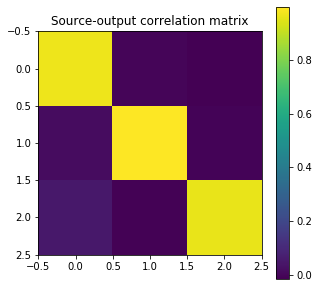

In [15]:
Y = np.zeros((trials,y_dim,iters)) # matrix for keeping track of the outputs across trials
error = np.zeros((trials,iters)) # matrix for keeping track of the error across trials

for n in range(trials):

    print('Trial {}:'.format(n+1))
    
    # noncentered whitening

    Cxx = np.cov(X_permuted[n,:,:])
    X_whitened = inv(sqrtm(Cxx))@X_permuted[n,:,:]
    
    # initialize weights

    W = np.random.randn(y_dim,x_dim)

    for i in range(y_dim):
        W[i,:] = W[i,:]/norm(W[i,:])

    start_time = time.time()

    for t in range(iters):

        eta_t = 1/(a+b*t)

        # input

        h = X_whitened[:,t]

        y = np.maximum(W@h,0); Y[n,:,t] = y

        # synaptic updates

        W = W + eta_t*(np.outer(y,h)-np.outer(y,y)@W)

        # check to see if any neurons (i.e. components of y) are not firing

        if t<=100:        
            for j in range(y_dim):
                if sum(Y[n,j,0:t])==0:
                    W[j,:] = -W[j,:]
                    print('flip',j)

        # output

        if (t+1)%(iters/report_num)==0:

            print('report number:', np.int((t+1)*report_num/iters))
        
            # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

            corr = np.corrcoef(S_permuted[n,:,:t+1],Y[n,:,:t+1])[:s_dim,s_dim:]

            fig=plt.figure(figsize=(5,5))

            plt.imshow(corr)
            plt.title('Source-output correlation matrix')
            plt.colorbar()
            plt.show()

    # compute the optimal permutation matrix

    perm = np.round(np.corrcoef(S_permuted[n,:,:],Y[n,:,:]))[:s_dim,s_dim:] # if the algorithm performs well, rounding the correlation matrix yields the optimal permutation matrix

    # compute error

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

cwd = os.getcwd() # current working directory  

path = f'{cwd}/error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/npca/a={a}/b={b}'

if os.path.exists(path)==False:
    os.makedirs(path)

np.save(f'{path}/error.npy', error)

# Comparisons

### Function for plotting confidence intervals

In [16]:
def add_ci_line(axis, t, data, ci_pct=68, plot_kwargs=None, ci_kwargs=None):
    mu = data.mean(axis=0)
    delta = (100 - ci_pct) / 2
    ci_lo = np.percentile(data, delta, axis=0)
    ci_hi = np.percentile(data, 100 - delta, axis=0)
    assert mu.shape == ci_lo.shape == ci_hi.shape
    plot_kwargs = plot_kwargs or {}
    ci_kwargs = ci_kwargs or {}
    plot = axis.plot(t, mu, **plot_kwargs)
    fill = axis.fill_between(t, ci_lo, ci_hi, alpha=.05, **ci_kwargs)
    return plot, fill

### Parameters

In [17]:
dataset = 'synthetic'
# dataset = 'images'

### Load data

In [29]:
# s_dim = 3
# x_dim = 3

# bio_nica_error = np.load(f'error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/bio-nica/a=100/b=0.1/tau=0.1/error.npy')
# nsm_error = np.load(f'error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/2nsm/a=10/b=0.8/error.npy')
# npca_error = np.load(f'error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/npca/a=1000/b=0.01/error.npy')

In [124]:
# s_dim = 10
# x_dim = 10

# bio_nica_error = np.load(f'error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/bio-nica/a=1000/b=0.1/tau=0.05/error.npy')
# nsm_error = np.load(f'error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/2nsm/a=10/b=0.8/error.npy')
# npca_error = np.load(f'error/{dataset}/{s_dim}-dim-source/{x_dim}-dim-mixture/npca/a=1000/b=0.01/error.npy')

### Sample efficiency

NameError: name 'bio_nica_error' is not defined

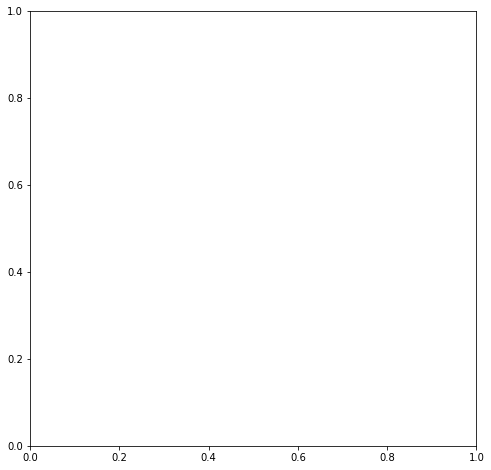

In [18]:
fig = plt.figure(figsize=(8,8))

linewidth = 3

t = list(range(iters))
ci = 90

ax = plt.subplot(1, 1, 1)
add_ci_line(
    ax,
    t,
    bio_nica_error,
    ci_pct = ci,
    plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA'},
)
add_ci_line(
    ax,
    t,
    nsm_error[0:3,:],
    ci_pct = ci,
    plot_kwargs={"ls": "--", "lw": linewidth, "label": "2-layer NSM"},
)
add_ci_line(
    ax,
    t,
    npca_error,
    ci_pct = ci,
    plot_kwargs={"ls": ":", "lw": linewidth, "label": "Nonnegative PCA (pre-whitened inputs)"},
)
ax.loglog()

plt.title(f'{s_dim}-dimensional {dataset} source data')

plt.xlabel('Sample #')
plt.ylabel('Error')
plt.xlim((10,iters))
plt.grid()
plt.legend(loc = 'lower left')

plt.savefig(f'plots/{dataset}_{s_dim}-dim_comparision.png', dpi=300, transparent='true', bbox_inches='tight')